# Работа с данными. Домашнее задание


## Задача
Имеется набор данных покупателей супермаркета. Проведите анализ и очистку этих данных.

### Описание данных

Дан файл Mall_Customers.csv, содержащий следующие данные по покупателям сети супермаркетов:
- CustomerID — идентификатор покупателя.
- Genre – пол покупателя.
- Age – возраст покупателя.
- Annual Income (k\$) – годовой доход покупателя, тысяч $.
- Spending Score (1–100) – рейтинг покупателя, целевая переменная.

### Задание 1

Загрузите данные из файла `Mall_Customers.csv` в ноутбук и выведите первые пять строк на экран.

In [373]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
from pathlib import Path
from sklearn.metrics import root_mean_squared_error

In [374]:
def calculate_iqr_boundaries(series, min_val=None, max_val=None, k_irq=None):
    if k_irq is None:
        k_irq = 1.5
    q25 = series.quantile(0.25)
    q75 = series.quantile(0.75)
    iqr = q75 - q25
    min_boundaries = q25 - k_irq * iqr
    max_boundaries = q75 + k_irq * iqr
    min_boundaries = min_val if min_val is not None and min_val >= min_boundaries else min_boundaries 
    max_boundaries = max_val if max_val is not None and max_val <= max_boundaries else max_boundaries 
    return (min_boundaries, max_boundaries)

In [375]:
dataset_filename = './Mall_Customers.csv'
df = pd.read_csv(dataset_filename)
df.head(3)

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19.0,15.0,39
1,2,Male,NaN,NaN,81
2,3,Female,NaN,16.0,6


### Задание 2

Проведите разведочный анализ загруженных данных. Обязательные атрибуты для анализа:
- количество пропусков в каждом признаке;
- распределения признаков;
- возможные выбросы или аномалии.

Анализ дополнительных атрибутов и свойств данных приветствуется. Используйте средства визуализации там, где это необходимо.

По результатам анализа сделайте выводы о свойствах отдельных признаков и качестве данных в целом.

In [376]:
# Сгруппируем основную информацию о датасете и выгрузим в excel.
# import io
info_filename = f'./{Path(dataset_filename).stem}_info.xlsx'
buf = io.StringIO()
df.info(buf=buf)
s = buf.getvalue()
columns = s.splitlines()[3].split()
lines =   [line.split() for line in s.splitlines()[5:-2]]
lines = [[' '.join(row[1:-3]), row[-3], row[-2], row[-1]   ] for row in lines]
df_info = pd.merge(
    pd.DataFrame(lines, columns=columns[1:])
    , df.nunique().to_frame(name='Nu'), 
    left_on='Column', 
    right_index=True)# .set_index(['#']).reset_index()
df_vc = pd.DataFrame([[col, sorted(df[col].value_counts().to_dict().items(), key=lambda x: x[0])] for col in df.columns if len(df[col].value_counts()) < 21], columns=['Column', 'vc'])
df_info = pd.merge(df_info, df_vc, how='left', on='Column')
df_info = pd.merge(df_info, df.describe().T, how='left', left_on='Column', right_index=True)
df_info = df_info[['Column', 'Non-Null']].copy()\
    .join(pd.DataFrame(df.isna().sum()).rename(columns={0: 'Null_cnt'}), how='left', on='Column')\
    .join(pd.DataFrame(df.isna().sum() / df.shape[0]).round(3).rename(columns={0: 'Null_percent'}), how='left', on='Column')\
    .join(df_info.set_index('Column').drop(columns=['Non-Null', 'Count'] ), how='left', on='Column')
if not Path(info_filename).exists():
    df_info.to_excel(info_filename, index=False)
df_info

,Column,Non-Null,Null_cnt,Null_percent,Dtype,Nu,vc,count,mean,std,min,25%,50%,75%,max
0,CustomerID,200,0,0.000,int64,200,NaN,200.0,100.500000,57.879185,1.0,50.75,100.5,150.25,200.0
1,Genre,181,19,0.095,object,3,"[(Feemale, 2), (Female, 102), (Male, 77)]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Age,180,20,0.100,float64,51,NaN,180.0,39.894444,16.842848,18.0,29.00,36.0,49.00,135.0
3,Annual Income (k$),180,20,0.100,float64,64,NaN,180.0,5615.433333,74531.115872,15.0,42.00,61.0,78.00,1000000.0
4,Spending Score (1-100),200,0,0.000,int64,84,NaN,200.0,50.200000,25.823522,1.0,34.75,50.0,73.00,99.0


In [377]:
null_values_indexes = set()
for col in df.columns:
    null_values_indexes.update(df.loc[df[col].isna()].index)
print(f'Количество уникальных элементов в датасете, имеющий пропуски : {len(null_values_indexes)}')
# Можно было и так df.isna().any(axis=1).sum(), но как показали измерения вычисления через множества работает в 6_000 (шесть тысяч раз) быстрее


Количество уникальных элементов в датасете, имеющий пропуски : 54


In [378]:
# Признак CustomerID не несет полезной нагрузки. Его можно удалить.
# Проверим появятся ли дубликаты в датасете после удаления признака CustomerID
df.loc[df.duplicated(set(df.columns).difference(['CustomerID']))].shape
# После удаления CustomerID дубликатов не должно появиться.

(0, 5)

In [379]:
# Как видим, дубликаты не появились. Признак можно удалить сразу.
df.drop(columns=['CustomerID'], inplace=True)
df.columns

Index(['Genre', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)'], dtype='object')

In [380]:
# И поменяем названия колонок на более короткие. Для удобства.
df.rename(columns={'Annual Income (k$)':'Income','Spending Score (1-100)': 'Score'}, inplace=True)
df.columns


Index(['Genre', 'Age', 'Income', 'Score'], dtype='object')

In [381]:
target_name = 'Score'
number_features = ['Age', 'Income'] # Отнесем признак Age к числовым переменным. Хотя можно ее рассматривать как категориальную, имеющую естественную порядковую связь.
cat_features = ['Genre']

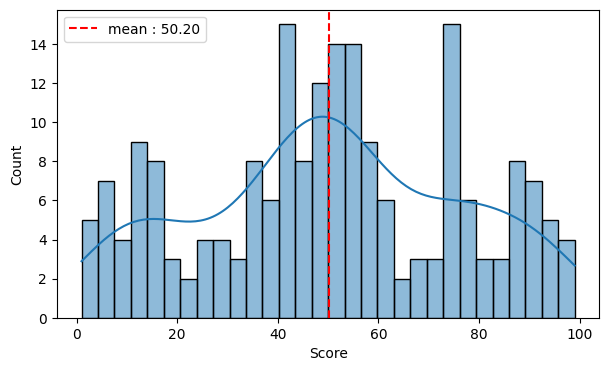

In [382]:
# Визуализируеум целевую переменную
target_feature_mean = df[target_name].mean()
plt.figure(figsize=(7,4))
g1 = sns.histplot(x=df[target_name], bins=30, kde=True);
g1.axvline(target_feature_mean, color='red', ls='--', label=f"mean : {target_feature_mean:,.2f}")
plt.legend();
# Распределение целевой переменной сложно отнести к нормальному. Значения распределены по всему диапазону.

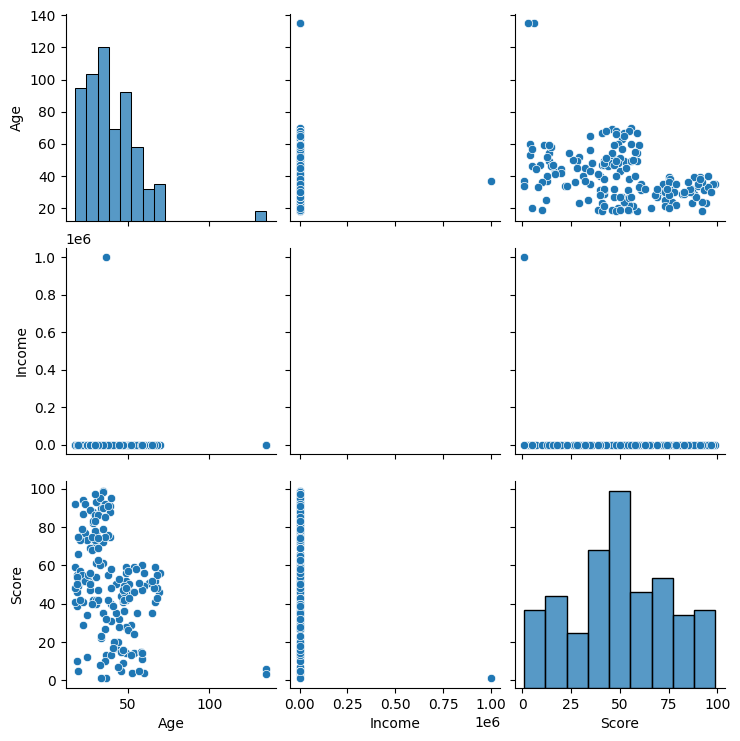

In [383]:
# Отобразим парную диаграмму числовых признаков, включая целевую переменную.
sns.pairplot(df[number_features + [target_name]]);
# Между признаком Age и целевой переменной не наблюдается какой то явной линейной зависимости.
# Отображению зависимости переменной Income мешает экстремальное значение. 
# Так же есть какое то экстремальное значение в признаке Age

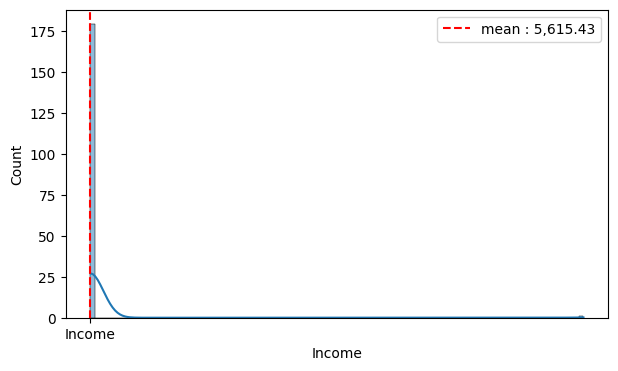

In [384]:
# Визуализируем числовой признак Income отдельно.
feature_name = 'Income'
feature_mean = df[feature_name].mean()
plt.figure(figsize=(7,4))
g1 = sns.histplot(x=df[feature_name], bins=100, kde=True);
g1.axvline(feature_name, color='red', ls='--', label=f"mean : {feature_mean:,.2f}")
plt.legend();


In [385]:
# Для корректного наблюдения признаков нужно уже сейчас предобаработать датасет

In [386]:
# Видим, что наблюдение, имеющие экстремальное значение в поле Income имеет самый низкий потребительский рейтинг.
# Скорее всего это просто опечатка или ошибка сбора данных
df.loc[df.Income > df.Income.quantile(0.95)].sort_values(['Income'], ascending=False).head(3)
# Просто удалим наблюдение



,Genre,Age,Income,Score
156,Male,37.0,1000000.0,1
198,Male,NaN,137.0,18
199,NaN,30.0,137.0,83


In [387]:
df.loc[df['Income'] == 1000000.0].index

Index([156], dtype='int64')

In [388]:
# Видим, что в признаке Age имеется экстремальное значение. Скорее всего ошибочное. Для целей построения графиков - удалим наблюдение
df.Age.value_counts().sort_index(ascending=False).head(3)

Age
135.0    2
70.0     1
69.0     1
Name: count, dtype: int64

In [389]:
df_tmp = df.copy()\
        .drop(index=df.loc[df['Income'] > 1000000.0 - 0.001].index)\
        .drop(index=df.loc[df['Age'] == 135].index)\
        .reset_index(drop=True)
# df_tmp = df.copy().drop(index=df.loc[df['Age'] == 135].index).reset_index(drop=True)
df_tmp['Genre'] = df_tmp['Genre'].replace({'Feemale' : 'Female'})
print(df_tmp.Income.max(), df_tmp.Age.max(), df_tmp.Genre.unique())

137.0 70.0 ['Male' 'Female' nan]


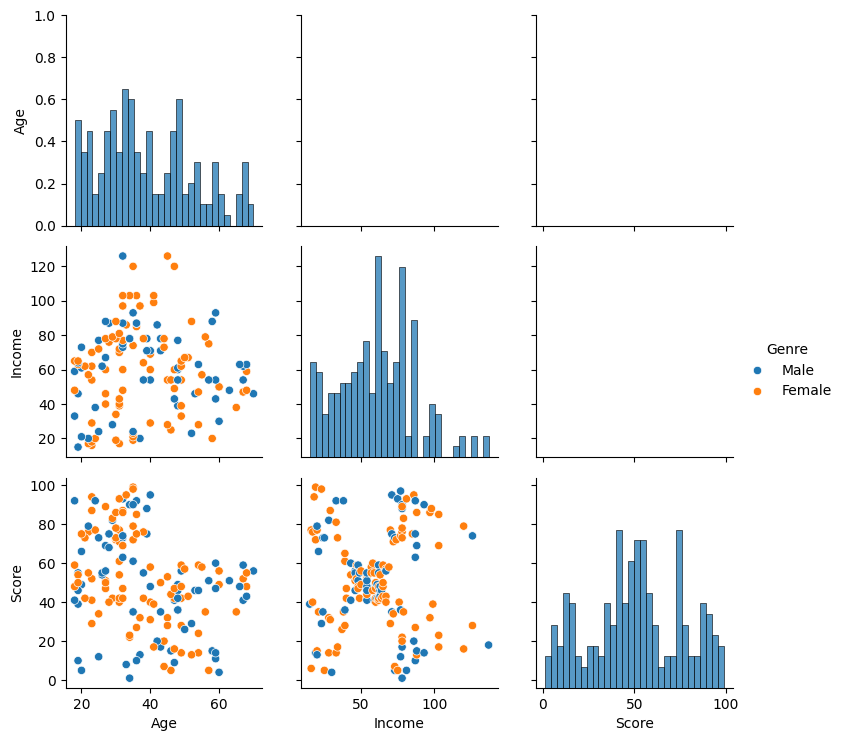

In [390]:
# Еще раз отобразим парную диаграмму числовых признаков
# Отобразим парную диаграмму числовых признаков, включая целевую переменную.
# sns.pairplot(df_tmp[number_features + [target_name]]);
g1 = sns.PairGrid(df_tmp, hue='Genre', height = 2.5)
g1.map_diag(sns.histplot, bins=30, hue=None)
g1.map_lower(sns.scatterplot)
g1.add_legend();

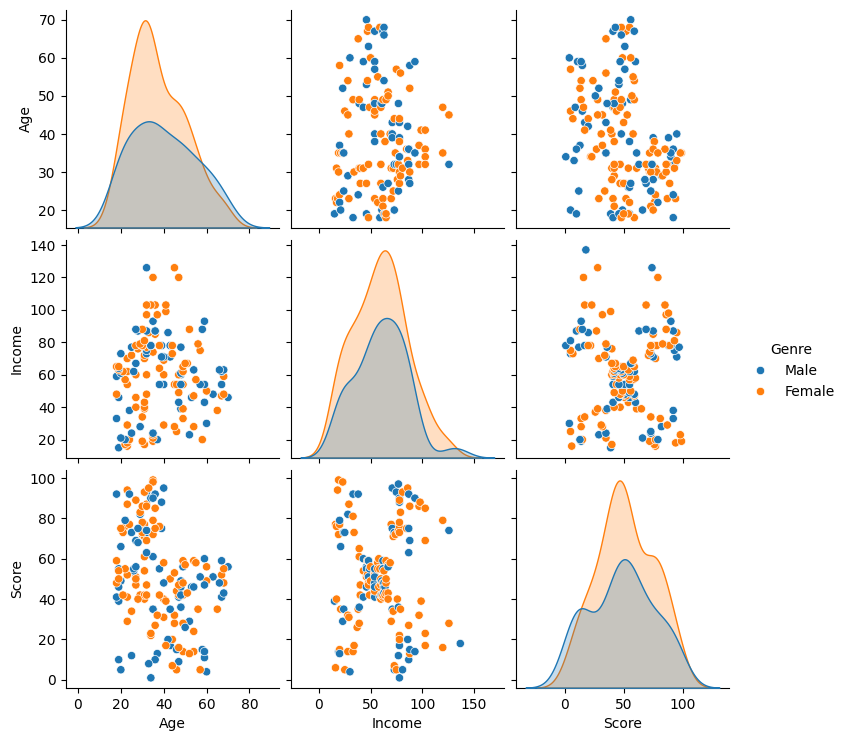

In [391]:
# Отобразим парные диаграммы в разрезе признака Genre
sns.pairplot(df_tmp, hue='Genre');
# Как видим, никакой явной зависимости признаков и целевой переменной от признака Genre не наблюдается.

<AxesSubplot: xlabel='Genre', ylabel='Score'>

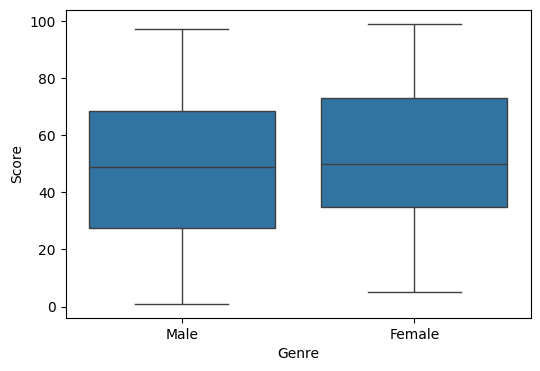

In [392]:
# Отобразим распределение целевой переменной в зависисмости от признака Genre 
plt.figure(figsize=(6,4))
sns.boxplot(x=df_tmp['Genre'], y=df_tmp['Score'])
# Видим, что целевая перемення с т.з. признака Genre явно не разделяется.

<AxesSubplot: xlabel='Age', ylabel='Score'>

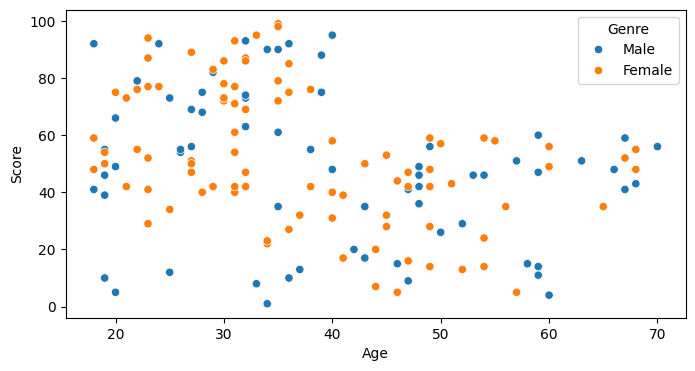

In [393]:
# Отобразим зависимость целевой переменной от признака Age
# Увы, какой то явной зависимости не наблюдается
plt.figure(figsize=(8,4))
sns.scatterplot(x=df_tmp.Age, y=df_tmp.Score, hue=df_tmp.Genre)

<AxesSubplot: xlabel='Income', ylabel='Score'>

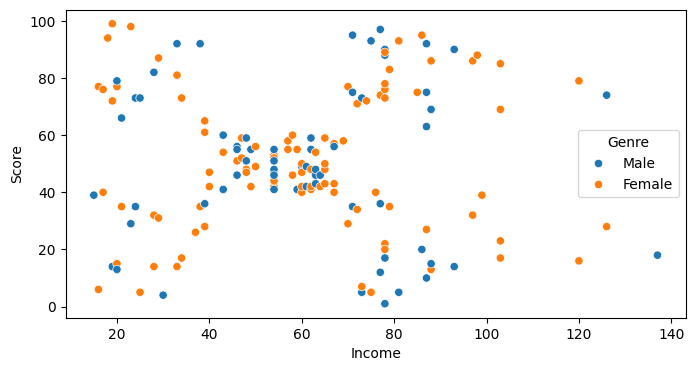

In [394]:
# Отобразим зависимость целевой переменной от признака Income
# Увы, какой то явной зависимости не наблюдается
plt.figure(figsize=(8,4))
sns.scatterplot(x=df_tmp.Income, y=df_tmp.Score, hue=df_tmp.Genre)

Выводы о качестве данных:
 - Количество уникальных элементов в датасете, имеющий пропуски : 54
 - В признаках Age и Income содержатся экстремальные значения: три уникальных записи
 - Признак Genre содержит опечатку в значении вместо Female написано Feemale

### Задание 3

Разделите данные на обучающую и тестовую выборки в пропорции 80:20. Здесь и далее используйте random_state = 1.

In [395]:
from sklearn.model_selection import train_test_split

In [396]:
# По мнению А.Груздев "Предварительная подготовка данных в Python" т.2 
# заполнение пропусков константами нужно делать до разделения датасета на обучающую и тестовую выборки
# Это так же нужно для того, чтобы корректно работали библиотеки разделения, в частности параметр "stratify"
df['Genre'] = df['Genre'].replace({'Feemale' : 'Female'})
# df['Genre'] = np.where(df['Genre'].isna(), 'Missing', df['Genre'].replace({'Feemale' : 'Female'}))

In [705]:

X_train, y_train, X_test, y_test = train_test_split(df[cat_features + number_features], df[target_name]\
                                                    , train_size=0.8\
                                                    , random_state=1
                                                    ,stratify=np.where(df['Genre'].isna(), 'Missing', df['Genre']))
print(f'{[el.shape for el in [X_train, y_train, X_test, y_test]]}')

[(160, 3), (40, 3), (160,), (40,)]


In [706]:
# Видим, что распределение меток признака Genre одинаковое, как до разделения, так и после
df.Genre.value_counts() / df.shape[0], X_train.Genre.value_counts() / X_train.shape[0]

(Genre
 Female    0.520
 Male      0.385
 Name: count, dtype: float64,
 Genre
 Female    0.51875
 Male      0.38750
 Name: count, dtype: float64)

### Задание 4

Заполните пропуски в признаках в обучающей выборке с использованием инструментов sklearn. Для каждого признака выберите и аргументируйте стратегию заполнения пропусков.

In [707]:
# pip install missingno 
import missingno as msno # Импортируем библиотеку для визуальной оценки пропусков.
# https://github.com/ResidentMario/missingno/blob/master/missingno/missingno.py
genre_str_to_num_dict = {'Male':0, 'Female':1}

In [708]:
# Воссоздадим первоначальный датасет, чтобы использоватье его для визуализации.
df_orig = df.copy()
# df_orig['Genre'] = df.Genre.replace({'Missing': np.NaN})

In [709]:
# Корреляция между признаками 
pd.DataFrame(df['Genre'].replace(genre_str_to_num_dict)).join(df[['Age', 'Income']]).corr()
# Как видим, практически отсутствует корреляция между пропусками

C:\Users\Alex\AppData\Local\Temp\ipykernel_10676\3353539274.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pd.DataFrame(df['Genre'].replace(genre_str_to_num_dict)).join(df[['Age', 'Income']]).corr()


,Genre,Age,Income
Genre,1.000000,-0.119309,-0.095248
Age,-0.119309,1.000000,-0.014366
Income,-0.095248,-0.014366,1.000000


C:\Users\Alex\AppData\Local\Temp\ipykernel_10676\1893358147.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  msno.heatmap(pd.DataFrame(df_orig['Genre'].replace(genre_str_to_num_dict)).join(df_orig[['Age', 'Income']]), figsize=(5,3), fontsize=10);
C:\Users\Alex\AppData\Local\Temp\ipykernel_10676\1893358147.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pd.DataFrame(df['Genre'].replace(genre_str_to_num_dict)).join(df[['Age', 'Income']]).isna().corr()


,Genre,Age,Income
Genre,1.000000,-5.115701e-02,5.684112e-03
Age,-0.051157,1.000000e+00,3.854941e-17
Income,0.005684,3.854941e-17,1.000000e+00


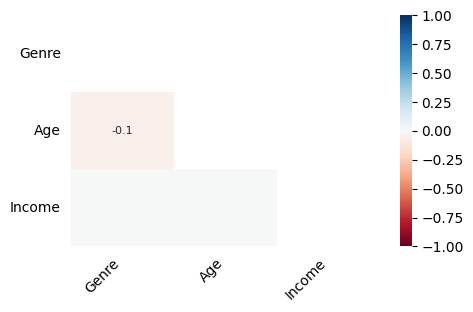

In [710]:
# Отобразим корреляцию пропусков в данных между признаками
# plt.figure(figsize=(4,4))
msno.heatmap(pd.DataFrame(df_orig['Genre'].replace(genre_str_to_num_dict)).join(df_orig[['Age', 'Income']]), figsize=(5,3), fontsize=10);
# Видим, что корреляция пропусков в данных между признаками можно сказать отсутствует
# pd.DataFrame(df_orig['Genre'].replace(genre_str_to_num_dict)).join(df_orig[['Age', 'Income']]).isna().corr()
pd.DataFrame(df['Genre'].replace(genre_str_to_num_dict)).join(df[['Age', 'Income']]).isna().corr()
# Что подтверждается матрицей корреляции

In [711]:
# Как рекомендует литература, есть смысл использовать разыные методы заполнения пропусков оценивая их результативность по результатам построения моделей:
# Ситуация далеко не тривиальная, т.к. разные методы применимы для разных моделей, вообщем это задача больше на опыт.
# Прочитал, что оценивать смысл заполнения пропусков можно следующим образом:
# а. наблюдения, где признак пропуск признака был заполнен каким то значением, 
# маркируется. После построения модели оценивается важность добавленного признака, обозначающего пропуск. 
# Если признак важен, то увеличение качества заполениня пропуска будет иметь значение для модели.
# б. экспериментировать с признаками, и смотреть на метрики модели.


Заполнение пропусков признака Genre

In [712]:
# Для обработки пропусков признака Genre, точно НЕ подойдет:
# 1. Удаление наблюдений, т.к. наблюдения с пропусками признака Genre составяляют 10% от объема выборки (многовато);
# 2. Заполнение каким то конкретным значением, соответствующим Female или Male, т.к. это может сильно повляить на распределение меток признака (хотя iterative_imputer так и сделал)).
# 3. Заполнение средним, медианой т.к. это не числовой признак.
# 4. Заполнение модой т.к. это будет слишком грубым заполнением (п.1 частный случай этого подхода)
# в т.ч. вышеуказанными среднегрупповыми значениями, т.к. анализ датасета не выявил явной линейной зависимости между Genre и другими признаками датасета.
# 5. Заполнение рандомным значением, если не получается добиться каких то приемлемых показателей при использовании других подходов.
# Для заполнения пропусков признака Genre, возможно использовать следующие подходы:
# 1. Т.к. явной корреляции между Genre и другими признаками, а так же между фактом пропуска и пропусками в других признаках содержащих 
# 1.1. пропуски отсутствует, пропуски можно заполнять случайными значениями из допустимого диапазона.
# 1.2. Заполнить специальным маркером "Missing";
# 2. Воспользоваться моделями, предназначенными для заполнения признка.
# 2.1. KNN
# 2.2. IterativeImputer 
# По хорошему бы провести тест Литтла для возможности отнесения к MCAR причин возникновения пропусков 
# (https://www.dmitrymakarov.ru/data-analysis/missing-add/)

In [713]:
# Попробуем использовать метод основанный на IterativeImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [714]:
X_train['Genre'] = X_train['Genre'].replace(genre_str_to_num_dict)

C:\Users\Alex\AppData\Local\Temp\ipykernel_10676\2829434500.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_train['Genre'] = X_train['Genre'].replace(genre_str_to_num_dict)


In [715]:
# Не указываем, про какой признак, т.к. модель обучается на всех признках датасета.
mice_imputer = IterativeImputer(random_state = 42)

In [716]:
mice_imputer.fit(X_train[['Genre', 'Age', 'Income']])

IterativeImputer(random_state=42)

In [717]:
# print(X_train.Genre.fillna(2).values.astype(int))
# print(mice_imputer.transform(X_train)[: , X_train.columns.get_loc('Genre')].round().astype(int))
col_name = 'Genre'
col_name_suffix = '_imp_mice'
col_name_new = col_name + col_name_suffix
if col_name_new in X_train.columns:
    X_train.drop(columns=[col_name_new], inplace=True)
X_train[col_name_new] = X_train[col_name].fillna(pd.Series(mice_imputer.transform(X_train[['Genre', 'Age', 'Income']])[: , X_train.columns.get_loc(col_name)].round().astype(int), X_train.index))
X_train.info()


<class 'pandas.core.frame.DataFrame'>
Index: 160 entries, 59 to 125
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Genre           145 non-null    float64
 1   Age             144 non-null    float64
 2   Income          143 non-null    float64
 3   Genre_imp_mice  160 non-null    float64
dtypes: float64(4)
memory usage: 6.2 KB


In [718]:
print(X_train.groupby([col_name])[['Age','Income']].median())
print(X_train.groupby([col_name_new])[['Age','Income']].median())
print((X_train[col_name].value_counts()/X_train.shape[0]).round(2))
print((X_train[col_name_new].value_counts()/X_train.shape[0]).round(2))
# Видим, что в результате заполнения пропусков признака Genre медианные значения Income не сместились, а  медианные значения признака Age сместились незначительно.
# При этом алгоритм посчитал, что пропущенные метки относились к классу со значением 1
# Наблюдаем, что медианные значения Income слабо различаются по признаку Genre

        Age  Income
Genre              
0.0    37.0    61.0
1.0    35.0    62.0
                 Age  Income
Genre_imp_mice              
0.0             37.0    61.0
1.0             36.0    62.0
Genre
1.0    0.52
0.0    0.39
Name: count, dtype: float64
Genre_imp_mice
1.0    0.61
0.0    0.39
Name: count, dtype: float64


In [719]:
# fig, axs = plt.subplots(1, 2, figsize=(5,3), sharey=True)
# fig.suptitle('Распределение целевой переменной')
# sns.histplot(ax=axs[0], data=X_train, x='Genre')
# sns.histplot(ax=axs[1], data=X_train, x='Genre_imp')

In [720]:
# В следующем ДЗ есть файл без пропусков, попробуем проверить результаты заполнения
df_true = pd.read_csv('../s7/Mall_Customers.csv')
df_true.rename(columns={'Annual Income (k$)':'Income','Spending Score (1-100)': 'Score'}, inplace=True)
df_true.columns

Index(['CustomerID', 'Genre', 'Age', 'Income', 'Score'], dtype='object')

In [721]:
true_col_name_suffix = '_true'
col_name_true = col_name + true_col_name_suffix
df_na = X_train.join(df_true, how='left', rsuffix=true_col_name_suffix).replace({col_name_true:{'Feemale' : 1,'Female' : 1,'Male' : 0}})\
        .query(f'{col_name}.isna() and {col_name_new} != {col_name_true}')
display(df_na)
display(df_na.shape[0])
# В тестовой выборке было 15 пропусков у признака Genre. Алгоритм корректно заполнил только 7 из них. Очень похоже на угадывание. Можно сказать, что примененный алгоритм был бесполезен

C:\Users\Alex\AppData\Local\Temp\ipykernel_10676\639914945.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_na = X_train.join(df_true, how='left', rsuffix=true_col_name_suffix).replace({col_name_true:{'Feemale' : 1,'Female' : 1,'Male' : 0}})\


,Genre,Age,Income,Genre_imp_mice,CustomerID,Genre_true,Age_true,Income_true,Score
32,NaN,53.0,33.0,1.0,33,0,53,33,4
199,NaN,30.0,137.0,1.0,200,0,30,137,83
185,NaN,30.0,99.0,1.0,186,0,30,99,97
110,NaN,65.0,63.0,1.0,111,0,65,63,52
57,NaN,69.0,44.0,1.0,58,0,69,44,46
123,NaN,39.0,NaN,1.0,124,0,39,69,91
129,NaN,38.0,71.0,1.0,130,0,38,71,75
51,NaN,33.0,42.0,1.0,52,0,33,42,60


8

In [722]:
# Попробуем применить KNN imputer
from sklearn.impute import KNNImputer

In [723]:
knn_imputer = KNNImputer(n_neighbors = 5)

In [724]:
knn_imputer.fit(X_train[['Genre', 'Age', 'Income']])

KNNImputer()

In [725]:
col_name_suffix = '_imp_knn'
col_name_new = col_name + col_name_suffix
if col_name_new in X_train.columns:
    X_train.drop(columns=[col_name_new], inplace=True)
X_train[col_name_new] = X_train[col_name].\
    fillna(pd.Series(knn_imputer.transform(X_train[['Genre', 'Age', 'Income']])[: , X_train.columns.get_loc(col_name)].round().astype(int), X_train.index))
display(X_train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 160 entries, 59 to 125
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Genre           145 non-null    float64
 1   Age             144 non-null    float64
 2   Income          143 non-null    float64
 3   Genre_imp_mice  160 non-null    float64
 4   Genre_imp_knn   160 non-null    float64
dtypes: float64(5)
memory usage: 11.6 KB


None

In [726]:
true_col_name_suffix = '_true'
col_name_true = col_name + true_col_name_suffix
df_na = X_train.join(df_true, how='left', rsuffix=true_col_name_suffix).replace({col_name_true:{'Feemale' : 1,'Female' : 1,'Male' : 0}})\
        .query(f'{col_name}.isna() and {col_name_new} != {col_name_true}')
display(df_na)
display(df_na.shape[0])
# В тестовой выборке было 15 пропусков у признака Genre. Алгоритм корректно заполнил только 6 из них. Алгоритм восстановил пропуски еще хуже, чем mice_imputer

C:\Users\Alex\AppData\Local\Temp\ipykernel_10676\2927579494.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_na = X_train.join(df_true, how='left', rsuffix=true_col_name_suffix).replace({col_name_true:{'Feemale' : 1,'Female' : 1,'Male' : 0}})\


,Genre,Age,Income,Genre_imp_mice,Genre_imp_knn,CustomerID,Genre_true,Age_true,Income_true,Score
56,NaN,51.0,44.0,1.0,0.0,57,1,51,44,50
32,NaN,53.0,33.0,1.0,1.0,33,0,53,33,4
50,NaN,49.0,42.0,1.0,0.0,51,1,49,42,52
185,NaN,30.0,99.0,1.0,1.0,186,0,30,99,97
154,NaN,47.0,78.0,1.0,0.0,155,1,47,78,16
110,NaN,65.0,63.0,1.0,1.0,111,0,65,63,52
106,NaN,NaN,63.0,1.0,0.0,107,1,66,63,50
57,NaN,69.0,44.0,1.0,1.0,58,0,69,44,46
51,NaN,33.0,42.0,1.0,1.0,52,0,33,42,60


9

In [727]:
# Попробуем обучить модель классификации
from sklearn.ensemble import GradientBoostingClassifier
model_genre_imputer = GradientBoostingClassifier()

col_name_suffix = '_imp_dt'
col_name_new = col_name + col_name_suffix
df_genre_imputer = X_train[['Genre', 'Age', 'Income']].dropna().copy()
X_genre_imputer = df_genre_imputer[['Age', 'Income']]
y_genre_imputer = df_genre_imputer[col_name]
model_genre_imputer.fit(X_genre_imputer, y_genre_imputer)
cond = (X_train[col_name].isna()) & (X_train['Age'].notna()) & (X_train['Income'].notna())
X_train[col_name_new] = \
    X_train.Genre.mask(X_train[col_name].isna(),\
    X_train.join(pd.DataFrame(model_genre_imputer.predict(X_train.loc[cond][['Age', 'Income']]), columns=['Genre_pred'], index=X_train.loc[cond].index), how='left')['Genre_pred'])
display(X_train.info())


<class 'pandas.core.frame.DataFrame'>
Index: 160 entries, 59 to 125
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Genre           145 non-null    float64
 1   Age             144 non-null    float64
 2   Income          143 non-null    float64
 3   Genre_imp_mice  160 non-null    float64
 4   Genre_imp_knn   160 non-null    float64
 5   Genre_imp_dt    157 non-null    float64
dtypes: float64(6)
memory usage: 12.8 KB


None

In [728]:
true_col_name_suffix = '_true'
col_name_true = col_name + true_col_name_suffix
df_na = X_train.join(df_true, how='left', rsuffix=true_col_name_suffix).replace({col_name_true:{'Feemale' : 1,'Female' : 1,'Male' : 0}})\
        .query(f'{col_name}.isna() and {col_name_new} != {col_name_true}')
display(df_na)
display(df_na.shape[0])
# Не удалось добиться какого то существенного прогесса по точности заполнения относительно класса IterativeImputer

C:\Users\Alex\AppData\Local\Temp\ipykernel_10676\2810702928.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_na = X_train.join(df_true, how='left', rsuffix=true_col_name_suffix).replace({col_name_true:{'Feemale' : 1,'Female' : 1,'Male' : 0}})\


,Genre,Age,Income,Genre_imp_mice,Genre_imp_knn,Genre_imp_dt,CustomerID,Genre_true,Age_true,Income_true,Score
32,NaN,53.0,33.0,1.0,1.0,1.0,33,0,53,33,4
199,NaN,30.0,137.0,1.0,0.0,1.0,200,0,30,137,83
185,NaN,30.0,99.0,1.0,1.0,1.0,186,0,30,99,97
54,NaN,50.0,NaN,1.0,1.0,NaN,55,1,50,43,45
106,NaN,NaN,63.0,1.0,0.0,NaN,107,1,66,63,50
6,NaN,135.0,18.0,1.0,1.0,0.0,7,1,35,18,6
123,NaN,39.0,NaN,1.0,0.0,NaN,124,0,39,69,91
51,NaN,33.0,42.0,1.0,1.0,1.0,52,0,33,42,60


8

Т.к. количество пропущенных значений для признака Genre составляет 20% от объема датасета.\
Существует вариант, помечать пропущенные значения отдельным маркером, что будет соответствовать добавлением класса с меткой 'Missing'\
Оценить результативность подходам можно будет по качеству модели.

In [729]:
X_train['Genre_imp_missing'] = X_train.Genre.mask(X_train.Genre.isna(), 3)
display(X_train['Genre_imp_missing'].value_counts())
display(X_train.info())

Genre_imp_missing
1.0    83
0.0    62
3.0    15
Name: count, dtype: int64

<class 'pandas.core.frame.DataFrame'>
Index: 160 entries, 59 to 125
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Genre              145 non-null    float64
 1   Age                144 non-null    float64
 2   Income             143 non-null    float64
 3   Genre_imp_mice     160 non-null    float64
 4   Genre_imp_knn      160 non-null    float64
 5   Genre_imp_dt       157 non-null    float64
 6   Genre_imp_missing  160 non-null    float64
dtypes: float64(7)
memory usage: 14.1 KB


None

Заполнение пропусков признка Income

In [730]:
# Исследуем гипотезу, можно ли заполнить пропуски средними значениями по группе.

display(X_train.groupby(['Genre', 'Age'], as_index=False).agg({'Income':['median', 'count', 'std']}).sort_values([('Income', 'std')], ascending=False).head(10)\
        .style.format({('Genre	'):'{:.0f}', ('Age'):'{:.0f}', ('Income','median'):'{:_.0f}',('Income','std'):'{:_.0f}'}))
display(X_train.groupby(['Age'], as_index=False).agg({'Income':['median', 'count', 'std']}).sort_values([('Income', 'std')], ascending=False).head(10).\
        style.format({('Income','median'):'{:_.0f}', ('Income','std'):'{:_.0f}'}))

# Судя по большой величине стандартного отклонения в группах, заполнение пропусков медианным значением по группе не очень хорошая идея.
# Но, других хороших гипотез нет. Начнем с нее.


In [731]:
# Для заполнения пропусков признака Income используем медианные значения по группам
col_name = 'Income'
col_name_suffix = '_imp_median'
col_name_new = col_name + col_name_suffix
col_name_gr1 = 'Genre'
col_name_gr2 = 'Age'
# X_train[col_name]
lower_boundaries, upper_boundaries = calculate_iqr_boundaries(X_train[col_name], min_val=0, k_irq=1.75)
# print(age_upper_boundaries)
if col_name_new in X_train.columns:
    X_train.drop(columns=[col_name_new], inplace=True)
target_by_gr1_gr2 = X_train.query(f'{col_name} >= {lower_boundaries} and {col_name} <= {upper_boundaries}').groupby([col_name_gr1, col_name_gr2]).agg({col_name:'median'})
X_train[col_name_new] = X_train[col_name].fillna(X_train[[col_name_gr1, col_name_gr2]].join(target_by_gr1_gr2, on=[col_name_gr1, col_name_gr2], how='left')[col_name])
# display(X_train.query(f'{col_name_new}.isna() and {col_name}.isna()'))
# display(age_by_genre_income)
target_by_gr2 = X_train.query(f'{col_name} >= {lower_boundaries} and {col_name} <= {upper_boundaries}').groupby([col_name_gr2]).agg({col_name:'median'})
X_train[col_name_new] = X_train[col_name_new].fillna(X_train[[col_name_gr2]].join(target_by_gr2, on=[col_name_gr2], how='left')[col_name])
target_by_gr1 = X_train.query(f'{col_name} >= {lower_boundaries} and {col_name} <= {upper_boundaries}').groupby([col_name_gr1]).agg({col_name:'median'})
X_train[col_name_new] = X_train[col_name_new].fillna(X_train[[col_name_gr1]].join(target_by_gr1, on=[col_name_gr1], how='left')[col_name])
if X_train[col_name_new].isna().sum() > 0:
    X_train[col_name_new] = X_train[col_name_new].fillna(X_train.query(f'{col_name} >= {lower_boundaries} and {col_name} <= {upper_boundaries}')[col_name].median())
X_train.info()
# Видим, что пропуски заполнены

<class 'pandas.core.frame.DataFrame'>
Index: 160 entries, 59 to 125
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Genre              145 non-null    float64
 1   Age                144 non-null    float64
 2   Income             143 non-null    float64
 3   Genre_imp_mice     160 non-null    float64
 4   Genre_imp_knn      160 non-null    float64
 5   Genre_imp_dt       157 non-null    float64
 6   Genre_imp_missing  160 non-null    float64
 7   Income_imp_median  160 non-null    float64
dtypes: float64(8)
memory usage: 15.3 KB


In [732]:
# Вычислим RMSE заполнения пропусков медианными значениями
true_col_name_suffix = '_true'
col_name_true = col_name + true_col_name_suffix
df_isna = X_train.join(df_true, how='left', rsuffix=true_col_name_suffix).query(f'{col_name}.isna()')[[col_name_new, col_name_true]]
display(df_isna)
print(f"RMSE ({col_name}):"\
       f"{(df_isna.apply(lambda x: ((x[col_name_true] - x[col_name_new])**2), axis=1).mean())**0.5}")

,Income_imp_median,Income_true
182,54.0,98
27,24.0,28
128,54.0,71
54,67.0,43
66,71.0,48
104,54.0,62
75,62.0,54
186,47.0,101
46,62.0,40
123,74.5,69


RMSE (Income):28.78444228480133


In [733]:
# Для заполнения пропусков признака Income используем обученную ранее модель IterativeImputer
col_name = 'Income'
col_name_suffix = '_imp_mice'
col_name_new = col_name + col_name_suffix
if col_name_new in X_train.columns:
    X_train.drop(columns=[col_name_new], inplace=True)
X_train[col_name_new] = \
        X_train[col_name].fillna(pd.Series(mice_imputer.transform(X_train[['Genre', 'Age', 'Income']])[: , X_train.columns.get_loc(col_name)].round().astype(int), X_train.index))
display(X_train.info())
display(X_train.query(f'{col_name}.isna()').head())


<class 'pandas.core.frame.DataFrame'>
Index: 160 entries, 59 to 125
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Genre              145 non-null    float64
 1   Age                144 non-null    float64
 2   Income             143 non-null    float64
 3   Genre_imp_mice     160 non-null    float64
 4   Genre_imp_knn      160 non-null    float64
 5   Genre_imp_dt       157 non-null    float64
 6   Genre_imp_missing  160 non-null    float64
 7   Income_imp_median  160 non-null    float64
 8   Income_imp_mice    160 non-null    float64
dtypes: float64(9)
memory usage: 16.6 KB


None

,Genre,Age,Income,Genre_imp_mice,Genre_imp_knn,Genre_imp_dt,Genre_imp_missing,Income_imp_median,Income_imp_mice
182,0.0,46.0,NaN,0.0,0.0,0.0,0.0,54.0,7054.0
27,0.0,35.0,NaN,0.0,0.0,0.0,0.0,24.0,7054.0
128,0.0,59.0,NaN,0.0,0.0,0.0,0.0,54.0,7054.0
54,NaN,50.0,NaN,1.0,1.0,NaN,3.0,67.0,7054.0
66,1.0,43.0,NaN,1.0,1.0,1.0,1.0,71.0,7054.0


In [734]:
# Вычислим RMSE заполнения пропусков предсказаниями модели IterativeImputer
true_col_name_suffix = '_true'
col_name_true = col_name + true_col_name_suffix
df_isna = X_train.join(df_true, how='left', rsuffix=true_col_name_suffix)\
    .query(f'{col_name}.isna()')[[col_name_new, col_name_true]]
display(df_isna)
print(f"RMSE ({col_name}):"\
       f"{(df_isna.apply(lambda x: ((x[col_name_true] - x[col_name_new])**2), axis=1).mean())**0.5}")

# Видим, что в качестве заполнителя предложено одно значение для всех пропущенных значений.
# Величина ошибки больше, чем при заполнении пропусков средним значением по группе.


,Income_imp_mice,Income_true
182,7054.0,98
27,7054.0,28
128,7054.0,71
54,7054.0,43
66,7054.0,48
104,7054.0,62
75,7054.0,54
186,7054.0,101
46,7054.0,40
123,7054.0,69


RMSE (Income):6988.759470834325


In [735]:
# Для заполнения пропусков признака Income используем обученную ранее модель KNN
col_name = 'Income'
col_name_suffix = '_imp_knn'
col_name_new = col_name + col_name_suffix
if col_name_new in X_train.columns:
    X_train.drop(columns=[col_name_new], inplace=True)
X_train[col_name_new] = \
        X_train[col_name].fillna(pd.Series(knn_imputer.transform(X_train[['Genre', 'Age', 'Income']])[: , X_train.columns.get_loc(col_name)].round().astype(int), X_train.index))
display(X_train.info())
display(X_train.query(f'{col_name}.isna()').head())

<class 'pandas.core.frame.DataFrame'>
Index: 160 entries, 59 to 125
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Genre              145 non-null    float64
 1   Age                144 non-null    float64
 2   Income             143 non-null    float64
 3   Genre_imp_mice     160 non-null    float64
 4   Genre_imp_knn      160 non-null    float64
 5   Genre_imp_dt       157 non-null    float64
 6   Genre_imp_missing  160 non-null    float64
 7   Income_imp_median  160 non-null    float64
 8   Income_imp_mice    160 non-null    float64
 9   Income_imp_knn     160 non-null    float64
dtypes: float64(10)
memory usage: 17.8 KB


None

,Genre,Age,Income,Genre_imp_mice,Genre_imp_knn,Genre_imp_dt,Genre_imp_missing,Income_imp_median,Income_imp_mice,Income_imp_knn
182,0.0,46.0,NaN,0.0,0.0,0.0,0.0,54.0,7054.0,71.0
27,0.0,35.0,NaN,0.0,0.0,0.0,0.0,24.0,7054.0,68.0
128,0.0,59.0,NaN,0.0,0.0,0.0,0.0,54.0,7054.0,65.0
54,NaN,50.0,NaN,1.0,1.0,NaN,3.0,67.0,7054.0,58.0
66,1.0,43.0,NaN,1.0,1.0,1.0,1.0,71.0,7054.0,51.0


In [736]:
# Вычислим RMSE заполнения пропусков предсказаниями модели KnnImputer
true_col_name_suffix = '_true'
col_name_true = col_name + true_col_name_suffix
df_isna = X_train.join(df_true, how='left', rsuffix=true_col_name_suffix)\
    .query(f'{col_name}.isna()')[[col_name_new, col_name_true]]
display(df_isna)
print(f"RMSE ({col_name}):"\
       f"{(df_isna.apply(lambda x: ((x[col_name_true] - x[col_name_new])**2), axis=1).mean())**0.5}")

# Видим, что при заполнении пропусков обученной моделью KNN ошибка наименьшая из всех трех примененных методов.
# Нужно сказать, что при заполнении пропусков важно не снизить ошибку, важно восстановить зависимость.
# Восстановления зависимости, похоже, не происходит ни в одном из использованных подходов.


,Income_imp_knn,Income_true
182,71.0,98
27,68.0,28
128,65.0,71
54,58.0,43
66,51.0,48
104,71.0,62
75,75.0,54
186,59.0,101
46,58.0,40
123,60.0,69


RMSE (Income):22.641710598440422


Заполнение пропусков признка Age

In [737]:
# Для заполнения пропущенных значений признака Age попробуем применить те же подходы, которые были применены при заполнении пропусков признака Income
# и оценим ошибку, которая получилась при заполнении
# Начнем с заполнения средними по группе
# Отобразим вариативность признака в получающихся группах
display(X_train.groupby(['Genre', 'Income'], as_index=False).agg({'Age':['median', 'count', 'std']}).sort_values([('Age', 'std')], ascending=False).head(10)\
        .style.format({('Genre	'):'{:.0f}', ('Income'):'{:.0f}', ('Age','median'):'{:_.0f}',('Age','std'):'{:_.0f}'}))
display(X_train.groupby(['Income'], as_index=False).agg({'Age':['median', 'count', 'std']}).sort_values([('Age', 'std')], ascending=False).head(10).\
        style.format({('Age','median'):'{:_.0f}', ('Age','std'):'{:_.0f}'}))

# Наблюдаем, что стандартное отклонение в группах, где есть, два признака может быть значительным, 
# что говорит о том, что опираться на среднегрупповые значения может быть не очень хорошей гипотезой, т.к. среднегрупповые значения не всегда обобщают значения признаков в группах

In [738]:
# Для заполнения пропусков признака Age используем медианные значения по группам
col_name = 'Age'
col_name_suffix = '_imp_median'
col_name_new = col_name + col_name_suffix
col_name_gr1 = 'Genre'
col_name_gr2 = 'Income'
# X_train[col_name]
lower_boundaries, upper_boundaries = calculate_iqr_boundaries(X_train[col_name], min_val=0, k_irq=1.75)
# print(age_upper_boundaries)
if col_name_new in X_train.columns:
    X_train.drop(columns=[col_name_new], inplace=True)
target_by_gr1_gr2 = X_train.query(f'{col_name} >= {lower_boundaries} and {col_name} <= {upper_boundaries}').groupby([col_name_gr1, col_name_gr2]).agg({col_name:'median'})
X_train[col_name_new] = X_train[col_name].fillna(X_train[[col_name_gr1, col_name_gr2]].join(target_by_gr1_gr2, on=[col_name_gr1, col_name_gr2], how='left')[col_name])
# display(X_train.query(f'{col_name_new}.isna() and {col_name}.isna()'))
# display(age_by_genre_income)
target_by_gr2 = X_train.query(f'{col_name} >= {lower_boundaries} and {col_name} <= {upper_boundaries}').groupby([col_name_gr2]).agg({col_name:'median'})
X_train[col_name_new] = X_train[col_name_new].fillna(X_train[[col_name_gr2]].join(target_by_gr2, on=[col_name_gr2], how='left')[col_name])
target_by_gr1 = X_train.query(f'{col_name} >= {lower_boundaries} and {col_name} <= {upper_boundaries}').groupby([col_name_gr1]).agg({col_name:'median'})
X_train[col_name_new] = X_train[col_name_new].fillna(X_train[[col_name_gr1]].join(target_by_gr1, on=[col_name_gr1], how='left')[col_name])
if X_train[col_name_new].isna().sum() > 0:
    X_train[col_name_new] = X_train[col_name_new].fillna(X_train.query(f'{col_name} >= {lower_boundaries} and {col_name} <= {upper_boundaries}')[col_name].median())
X_train.info()
# Видим, что пропуски заполнены

<class 'pandas.core.frame.DataFrame'>
Index: 160 entries, 59 to 125
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Genre              145 non-null    float64
 1   Age                144 non-null    float64
 2   Income             143 non-null    float64
 3   Genre_imp_mice     160 non-null    float64
 4   Genre_imp_knn      160 non-null    float64
 5   Genre_imp_dt       157 non-null    float64
 6   Genre_imp_missing  160 non-null    float64
 7   Income_imp_median  160 non-null    float64
 8   Income_imp_mice    160 non-null    float64
 9   Income_imp_knn     160 non-null    float64
 10  Age_imp_median     160 non-null    float64
dtypes: float64(11)
memory usage: 19.1 KB


In [739]:
# Вычислим RMSE заполнения пропусков средними значениями признака Age.
true_col_name_suffix = '_true'
col_name_true = col_name + true_col_name_suffix
df_isna = X_train.join(df_true, how='left', rsuffix=true_col_name_suffix)\
    .query(f'{col_name}.isna()')[[col_name_new, col_name_true]]
display(df_isna)
print(f"RMSE ({col_name}):"\
       f"{(df_isna.apply(lambda x: ((x[col_name_true] - x[col_name_new])**2), axis=1).mean())**0.5}")



,Age_imp_median,Age_true
145,36.5,28
116,19.0,63
183,35.0,29
2,35.0,20
198,30.0,32
162,31.0,19
106,65.0,66
121,50.0,38
46,35.0,50
89,35.0,50


RMSE (Age):16.360680762119895


In [740]:
# Заполним пропуски в признаке Age c использованием обученной модели IterativeImputer

col_name = 'Age'
col_name_suffix = '_imp_mice'
col_name_new = col_name + col_name_suffix
if col_name_new in X_train.columns:
    X_train.drop(columns=[col_name_new], inplace=True)
X_train[col_name_new] = \
        X_train[col_name].fillna(pd.Series(mice_imputer.transform(X_train[['Genre', 'Age', 'Income']])[: , X_train.columns.get_loc(col_name)].round().astype(int), X_train.index))
display(X_train.info())
display(X_train.query(f'{col_name}.isna()').head())
# Странно, что заполненеие выполняется одинаковыми значениями

<class 'pandas.core.frame.DataFrame'>
Index: 160 entries, 59 to 125
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Genre              145 non-null    float64
 1   Age                144 non-null    float64
 2   Income             143 non-null    float64
 3   Genre_imp_mice     160 non-null    float64
 4   Genre_imp_knn      160 non-null    float64
 5   Genre_imp_dt       157 non-null    float64
 6   Genre_imp_missing  160 non-null    float64
 7   Income_imp_median  160 non-null    float64
 8   Income_imp_mice    160 non-null    float64
 9   Income_imp_knn     160 non-null    float64
 10  Age_imp_median     160 non-null    float64
 11  Age_imp_mice       160 non-null    float64
dtypes: float64(12)
memory usage: 20.3 KB


None

,Genre,Age,Income,Genre_imp_mice,Genre_imp_knn,Genre_imp_dt,Genre_imp_missing,Income_imp_median,Income_imp_mice,Income_imp_knn,Age_imp_median,Age_imp_mice
145,0.0,NaN,77.0,0.0,0.0,0.0,0.0,77.0,77.0,77.0,36.5,39.0
116,1.0,NaN,65.0,1.0,1.0,1.0,1.0,65.0,65.0,65.0,19.0,39.0
183,1.0,NaN,98.0,1.0,1.0,1.0,1.0,98.0,98.0,98.0,35.0,39.0
2,1.0,NaN,16.0,1.0,1.0,1.0,1.0,16.0,16.0,16.0,35.0,39.0
198,0.0,NaN,137.0,0.0,0.0,0.0,0.0,137.0,137.0,137.0,30.0,39.0


In [741]:
true_col_name_suffix = '_true'
col_name_true = col_name + true_col_name_suffix
df_isna = X_train.join(df_true, how='left', rsuffix=true_col_name_suffix)\
    .query(f'{col_name}.isna()')[[col_name_new, col_name_true]]
display(df_isna)
print(f"RMSE ({col_name}):"\
       f"{(df_isna.apply(lambda x: ((x[col_name_true] - x[col_name_new])**2), axis=1).mean())**0.5}")

# Видим, что в качестве заполнителя предложено одно значение для всех пропущенных значений.
# Величина ошибки чуть меньше, чем при заполнении пропусков средним значением по группе.

,Age_imp_mice,Age_true
145,39.0,28
116,39.0,63
183,39.0,29
2,39.0,20
198,39.0,32
162,39.0,19
106,39.0,66
121,39.0,38
46,39.0,50
89,39.0,50


RMSE (Age):15.722197683530124


In [742]:
# Для заполнения пропусков признака Age используем обученную ранее модель KNN
col_name = 'Age'
col_name_suffix = '_imp_knn'
col_name_new = col_name + col_name_suffix
if col_name_new in X_train.columns:
    X_train.drop(columns=[col_name_new], inplace=True)
X_train[col_name_new] = \
        X_train[col_name].fillna(pd.Series(knn_imputer.transform(X_train[['Genre', 'Age', 'Income']])[: , X_train.columns.get_loc(col_name)].round().astype(int), X_train.index))
display(X_train.info())
display(X_train.query(f'{col_name}.isna()').head())

<class 'pandas.core.frame.DataFrame'>
Index: 160 entries, 59 to 125
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Genre              145 non-null    float64
 1   Age                144 non-null    float64
 2   Income             143 non-null    float64
 3   Genre_imp_mice     160 non-null    float64
 4   Genre_imp_knn      160 non-null    float64
 5   Genre_imp_dt       157 non-null    float64
 6   Genre_imp_missing  160 non-null    float64
 7   Income_imp_median  160 non-null    float64
 8   Income_imp_mice    160 non-null    float64
 9   Income_imp_knn     160 non-null    float64
 10  Age_imp_median     160 non-null    float64
 11  Age_imp_mice       160 non-null    float64
 12  Age_imp_knn        160 non-null    float64
dtypes: float64(13)
memory usage: 21.6 KB


None

,Genre,Age,Income,Genre_imp_mice,Genre_imp_knn,Genre_imp_dt,Genre_imp_missing,Income_imp_median,Income_imp_mice,Income_imp_knn,Age_imp_median,Age_imp_mice,Age_imp_knn
145,0.0,NaN,77.0,0.0,0.0,0.0,0.0,77.0,77.0,77.0,36.5,39.0,35.0
116,1.0,NaN,65.0,1.0,1.0,1.0,1.0,65.0,65.0,65.0,19.0,39.0,30.0
183,1.0,NaN,98.0,1.0,1.0,1.0,1.0,98.0,98.0,98.0,35.0,39.0,38.0
2,1.0,NaN,16.0,1.0,1.0,1.0,1.0,16.0,16.0,16.0,35.0,39.0,34.0
198,0.0,NaN,137.0,0.0,0.0,0.0,0.0,137.0,137.0,137.0,30.0,39.0,31.0


In [743]:
# Вычислим RMSE заполнения пропусков признака Age предсказаниями модели KnnImputer
true_col_name_suffix = '_true'
col_name_true = col_name + true_col_name_suffix
df_isna = X_train.join(df_true, how='left', rsuffix=true_col_name_suffix)\
    .query(f'{col_name}.isna()')[[col_name_new, col_name_true]]
display(df_isna)
print(f"RMSE ({col_name}):"\
       f"{(df_isna.apply(lambda x: ((x[col_name_true] - x[col_name_new])**2), axis=1).mean())**0.5}")

# Видим, что при заполнении пропусков обученной моделью KNN ошибка наименьшая из всех трех примененных методов.
# Нужно сказать, что при заполнении пропусков важно не снизить ошибку, важно восстановить зависимость.
# Восстановления зависимости, похоже, не происходит ни в одном из использованных подходов.


,Age_imp_knn,Age_true
145,35.0,28
116,30.0,63
183,38.0,29
2,34.0,20
198,31.0,32
162,42.0,19
106,54.0,66
121,39.0,38
46,42.0,50
89,39.0,50


RMSE (Age):15.63449711375457


In [782]:
X_train = X_train_cp.copy(deep=True)

In [783]:
# X_train_cp = X_train.copy(deep=True)
# X_train = X_train_cp.copy(deep=True)
# Заполним пропуски результатом подхода с наименьшими ошибками.
X_train['Genre'] = X_train['Genre_imp_mice']
X_train['Income'] = X_train['Income_imp_knn']
X_train['Age'] = X_train['Age_imp_knn']
X_train = X_train[['Genre', 'Age', 'Income']]
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 160 entries, 59 to 125
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Genre   160 non-null    float64
 1   Age     160 non-null    float64
 2   Income  160 non-null    float64
dtypes: float64(3)
memory usage: 9.1 KB


### Задание 5

Найдите выбросы в признаках обучающей выборки. Замените выбросы, если таковые имеются, и аргументируйте выбор метода поиска выбросов.


In [784]:
# Выбросы в признаке Genre были обработаны ранее, т.к. обработка выбросов должна происходить до заполнения пропусков.
# 1. Если делать наоборот, то при построении моделей заполнения пропусков средними значениями и результатами работы моделей то на них будут оказывать влияние выбросы.
# 2. Некоторые выбросы, можно интерпретировать как пропуски и обрабатывать их на этапе заполнения пропусков.
df['Genre'].value_counts()
# В первоначальном датасете встречалось значение Feemale, которое было явной опечаткой и было заменено ранее на правильное значение


Genre
Female    104
Male       77
Name: count, dtype: int64

Обработка выбросов для признака Income

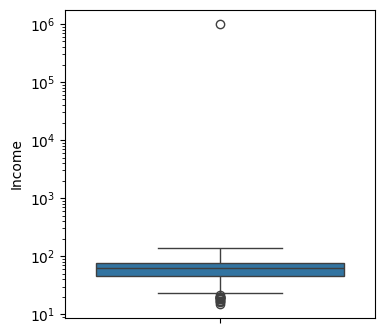

In [785]:
# Найдем выбросы для признака Income
plt.figure(figsize=(4,4))
sns.boxplot(data=X_train, y='Income', log_scale=True);
# Отобразим признак с примененеим логарифмической шкалы. Видим единичный выброс, который явно является неправильным значением.
# Отрицательных значений дохода нет.

In [786]:
# Рассчитаем граничные значения при коэффициенте интерквартильного размаха 1,75
lower_boundaries, upper_boundaries = calculate_iqr_boundaries(X_train['Income'], min_val=0, k_irq=1.75)
display(lower_boundaries, upper_boundaries)
out_of_boundaries_index = X_train.query(f'Income >= {upper_boundaries}').index
X_train.loc[out_of_boundaries_index]
# Видим, что значение выходящее за границы верхней границы диапазона, в котором мы считаем, что могут находиться значения признака только одно.
# Как было уже сказано выше, такие выбросы, т.к. исходное значение полностью утранчено, было бы правильным заполнить как пропуск (а не верхним значением диапазиона).


0

131.25

,Genre,Age,Income
199,1.0,30.0,137.0
198,0.0,31.0,137.0
156,0.0,37.0,1000000.0


In [787]:
# Т.к. наилучшие результаты (с т.з. ошибки для восстановленных значений) дает заполнение пропусков моделью KNNImputer, то так и поступим.
col_name = 'Income'
X_train.loc[(X_train[col_name] > upper_boundaries) | (X_train[col_name] < lower_boundaries), col_name] = np.nan
X_train.loc[out_of_boundaries_index]



,Genre,Age,Income
199,1.0,30.0,NaN
198,0.0,31.0,NaN
156,0.0,37.0,NaN


In [788]:
col_name = 'Income'
X_train[col_name] = \
        X_train[col_name].fillna(pd.Series(knn_imputer.transform(X_train[['Genre', 'Age', 'Income']])[: , X_train.columns.get_loc(col_name)].round().astype(int), X_train.index))
display(X_train.info())
display(X_train.loc[out_of_boundaries_index])
display(X_train.loc[(X_train[col_name] > upper_boundaries) | (X_train[col_name] < lower_boundaries), col_name])
# Эксперимент не удался, одно из значений предсказанных KNNImputer оказалось так же не попадающим в диапазон, которй считаем допустимым.


<class 'pandas.core.frame.DataFrame'>
Index: 160 entries, 59 to 125
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Genre   160 non-null    float64
 1   Age     160 non-null    float64
 2   Income  160 non-null    float64
dtypes: float64(3)
memory usage: 9.1 KB


None

,Genre,Age,Income
199,1.0,30.0,72.0
198,0.0,31.0,66.0
156,0.0,37.0,200039.0


156    200039.0
Name: Income, dtype: float64

In [789]:
# Дополнительно, применим способ установки граничных значений диапазона, для значений выходящих за границы.
out_of_boundaries_index_2 = X_train.query(f'Income > {upper_boundaries} or Income < {lower_boundaries}').index
display(X_train.loc[out_of_boundaries_index_2])
X_train.loc[(X_train[col_name] > upper_boundaries), col_name] = upper_boundaries
X_train.loc[(X_train[col_name] < lower_boundaries), col_name] = lower_boundaries
display(X_train.loc[out_of_boundaries_index_2])

,Genre,Age,Income
156,0.0,37.0,200039.0


,Genre,Age,Income
156,0.0,37.0,131.25


Обработка выбросов для признака Age

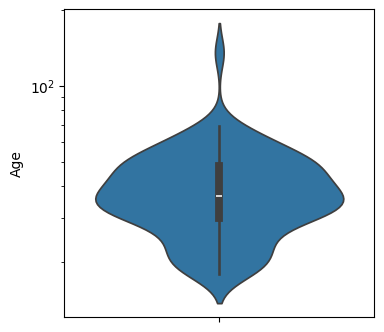

In [790]:
# Найдем выбросы для признака Age
col_name = 'Age'
plt.figure(figsize=(4,4))
sns.violinplot(data=X_train, y=col_name, log_scale=True);
# Отобразим признак с примененеим логарифмической шкалы. Видим единичный выброс, который явно является неправильным значением с т.з. признака.
# Отрицательных значений признака нет.

In [791]:
# Рассчитаем граничные значения при коэффициенте интерквартильного размаха 1,75
lower_boundaries, upper_boundaries = calculate_iqr_boundaries(X_train[col_name], min_val=0, k_irq=1.75)
display(lower_boundaries, upper_boundaries)
out_of_boundaries_index = X_train.query(f'{col_name} >= {upper_boundaries}').index
X_train.loc[out_of_boundaries_index]
# Видим, что количество наблюдений, имеющих значение признака, выходящее за границы диапазона, два.
# Как было уже сказано выше, такие выбросы, т.к. исходное значение полностью утранчено, было бы правильным попытаться заполнить как пропуск (а не верхним значением диапазиона).

0

79.5

,Genre,Age,Income
8,0.0,135.0,19.0
6,1.0,135.0,18.0


In [792]:
X_train.loc[(X_train[col_name] > upper_boundaries) | (X_train[col_name] < lower_boundaries), col_name] = np.nan
X_train.loc[out_of_boundaries_index]

,Genre,Age,Income
8,0.0,NaN,19.0
6,1.0,NaN,18.0


In [793]:
X_train[col_name] = \
        X_train[col_name].fillna(pd.Series(knn_imputer.transform(X_train[['Genre', 'Age', 'Income']])[: , X_train.columns.get_loc(col_name)].round().astype(int), X_train.index))
display(X_train.info())
display(X_train.loc[out_of_boundaries_index])
display(X_train.loc[(X_train[col_name] > upper_boundaries) | (X_train[col_name] < lower_boundaries), col_name])
# Эксперимент удался, значения предсказанных KNNImputer попали в диапазон, которй считаем допустимым.

<class 'pandas.core.frame.DataFrame'>
Index: 160 entries, 59 to 125
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Genre   160 non-null    float64
 1   Age     160 non-null    float64
 2   Income  160 non-null    float64
dtypes: float64(3)
memory usage: 9.1 KB


None

,Genre,Age,Income
8,0.0,32.0,19.0
6,1.0,55.0,18.0


Series([], Name: Age, dtype: float64)

### Задание 6

Нормализуйте численные признаки. Аргументируйте выбор стратегии нормализации для каждого признака.


In [794]:
# Т.к. мы избавились от выбросов, то наиболее предпочтительным является использование StandartScaler.
# Считается, что MinMaxScaler лучше работает на признаках содержащих выбросы.
from sklearn.preprocessing import StandardScaler

In [795]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns, index=X_train.index)

In [796]:
X_train_scaled.describe()

,Genre,Age,Income
count,1.600000e+02,1.600000e+02,1.600000e+02
mean,-4.996004e-17,-1.054712e-16,5.828671e-17
std,1.003140e+00,1.003140e+00,1.003140e+00
min,-1.257237e+00,-1.601085e+00,-1.944512e+00
25%,-1.257237e+00,-6.452135e-01,-6.332337e-01
50%,7.953949e-01,-1.672776e-01,4.355506e-02
75%,7.953949e-01,7.288523e-01,6.780445e-01
max,7.953949e-01,2.461370e+00,2.972781e+00


### Задание 7

Закодируйте категориальные признаки в обучающей выборке. Аргументируйте выбор способа кодирования.

In [703]:
# Кодирование категориального признака Genre было выполнено ранее. Иначе предобработка бы не получилась.

### Задание 8
Проведите очистку и подготовку тестовых данных. Используйте препроцессоры и другие инструменты, которые вы уже использовали при подготовке обучающей выборки, без их дополнительной настройки.

In [704]:
Здесь нужно написать класс DataPreprocessing
Содержащий два публичных метода fit и transform в который нужно разместить код по преобразованию признаков.
